In [2]:
import os
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import warnings

In [3]:
# Download dataset
path = kagglehub.dataset_download("rohanrao/formula-1-world-championship-1950-2020")
print("Dataset stored at:", path)

# CSV paths
drivers_path = os.path.join(path, "drivers.csv")
races_path = os.path.join(path, "races.csv")
results_path = os.path.join(path, "results.csv")
qualifying_path = os.path.join(path, "qualifying.csv")

# Load the CSVs
df_drivers = pd.read_csv(drivers_path)
df_races = pd.read_csv(races_path)
df_results = pd.read_csv(results_path)
df_qualifying = pd.read_csv(qualifying_path)

# Quick check
print("Drivers:", df_drivers.shape)
print("Races:", df_races.shape)
print("Results:", df_results.shape)
print("Qualifying:", df_qualifying.shape)

Using Colab cache for faster access to the 'formula-1-world-championship-1950-2020' dataset.
Dataset stored at: /kaggle/input/formula-1-world-championship-1950-2020
Drivers: (861, 9)
Races: (1125, 18)
Results: (26759, 18)
Qualifying: (10494, 9)


In [4]:
#  Checking for missing values in each dataset
print("Missing values in Drivers dataset:\n", df_drivers.isnull().sum())
print("\nMissing values in Races dataset:\n", df_races.isnull().sum())
print("\nMissing values in Results dataset:\n", df_results.isnull().sum())
print("\nMissing values in Qualifying dataset:\n", df_qualifying.isnull().sum())

#  Dropping rows with missing values
df_drivers.dropna(inplace=True)
df_races.dropna(inplace=True)
df_results.dropna(inplace=True)
df_qualifying.dropna(inplace=True)

#  Verifying if missing values still exist
print("\nAfter cleaning:")
print("Drivers:", df_drivers.isnull().sum().sum(), "missing values")
print("Races:", df_races.isnull().sum().sum(), "missing values")
print("Results:", df_results.isnull().sum().sum(), "missing values")
print("Qualifying:", df_qualifying.isnull().sum().sum(), "missing values")

Missing values in Drivers dataset:
 driverId       0
driverRef      0
number         0
code           0
forename       0
surname        0
dob            0
nationality    0
url            0
dtype: int64

Missing values in Races dataset:
 raceId         0
year           0
round          0
circuitId      0
name           0
date           0
time           0
url            0
fp1_date       0
fp1_time       0
fp2_date       0
fp2_time       0
fp3_date       0
fp3_time       0
quali_date     0
quali_time     0
sprint_date    0
sprint_time    0
dtype: int64

Missing values in Results dataset:
 resultId           0
raceId             0
driverId           0
constructorId      0
number             0
grid               0
position           0
positionText       0
positionOrder      0
points             0
laps               0
time               0
milliseconds       0
fastestLap         0
rank               0
fastestLapTime     0
fastestLapSpeed    0
statusId           0
dtype: int64

Missing values 

In [5]:
#  Checking dataset dimensions
print("Drivers dataset shape:", df_drivers.shape)
print("Races dataset shape:", df_races.shape)
print("Results dataset shape:", df_results.shape)
print("Qualifying dataset shape:", df_qualifying.shape)

#  Basic information and statistics
print("\nDrivers dataset info:")
df_drivers.info()

print("\nRaces dataset info:")
df_races.info()

print("\nResults dataset info:")
df_results.info()

Drivers dataset shape: (861, 9)
Races dataset shape: (1125, 18)
Results dataset shape: (26759, 18)
Qualifying dataset shape: (10448, 9)

Drivers dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 861 entries, 0 to 860
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   driverId     861 non-null    int64 
 1   driverRef    861 non-null    object
 2   number       861 non-null    object
 3   code         861 non-null    object
 4   forename     861 non-null    object
 5   surname      861 non-null    object
 6   dob          861 non-null    object
 7   nationality  861 non-null    object
 8   url          861 non-null    object
dtypes: int64(1), object(8)
memory usage: 60.7+ KB

Races dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 18 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   raceId       1125 no

**Which drivers have the most race wins in Formula 1 history?**

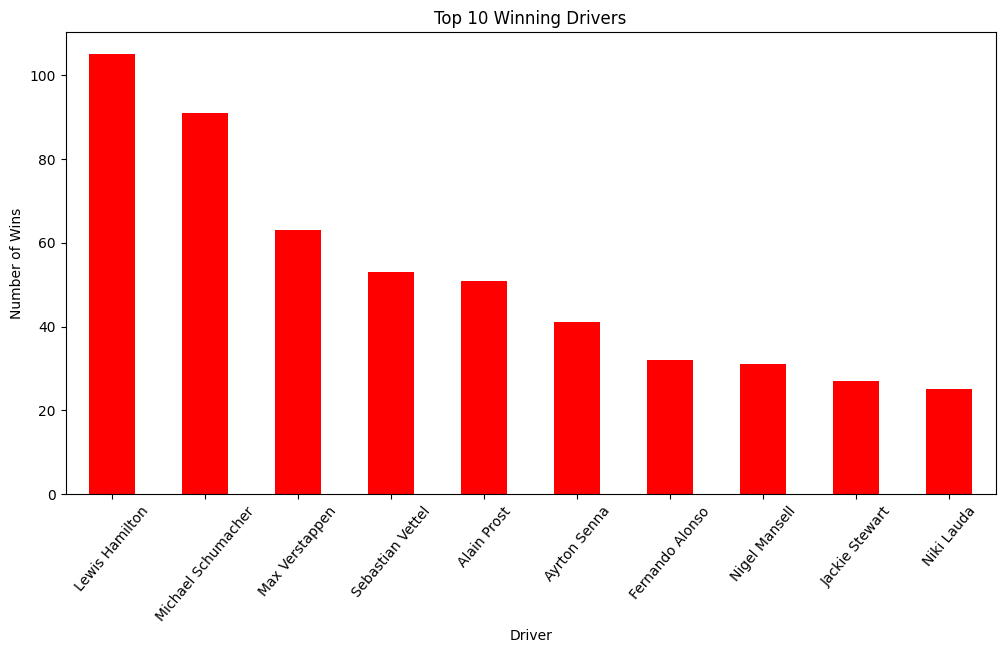

In [6]:
# Merging results with drivers to get driver names for winners
winners = df_results[df_results['positionOrder'] == 1]  # positionOrder == 1 means race winner
winners = winners.merge(df_drivers, left_on='driverId', right_on='driverId')

# Counting top winning drivers
winners['driver_name'] = winners['forename'] + ' ' + winners['surname']
top_winners = winners['driver_name'].value_counts().head(10)

plt.figure(figsize=(12,6))
top_winners.plot(kind='bar', color='red')
plt.title("Top 10 Winning Drivers")
plt.xlabel("Driver")
plt.ylabel("Number of Wins")
plt.xticks(rotation=50)
plt.show()

**How has the number of races per season changed over time?**

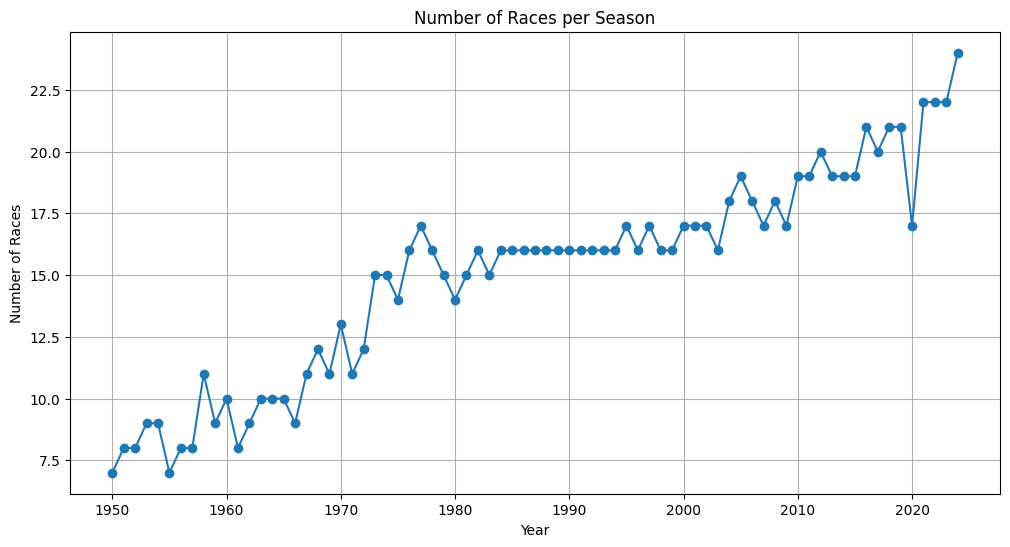

In [7]:
races_per_year = df_races['year'].value_counts().sort_index()

plt.figure(figsize=(12,6))
races_per_year.plot(kind='line', marker='o')
plt.title("Number of Races per Season")
plt.xlabel("Year")
plt.ylabel("Number of Races")
plt.grid(True)
plt.show()

**Which circuits host the most Formula 1 races?**

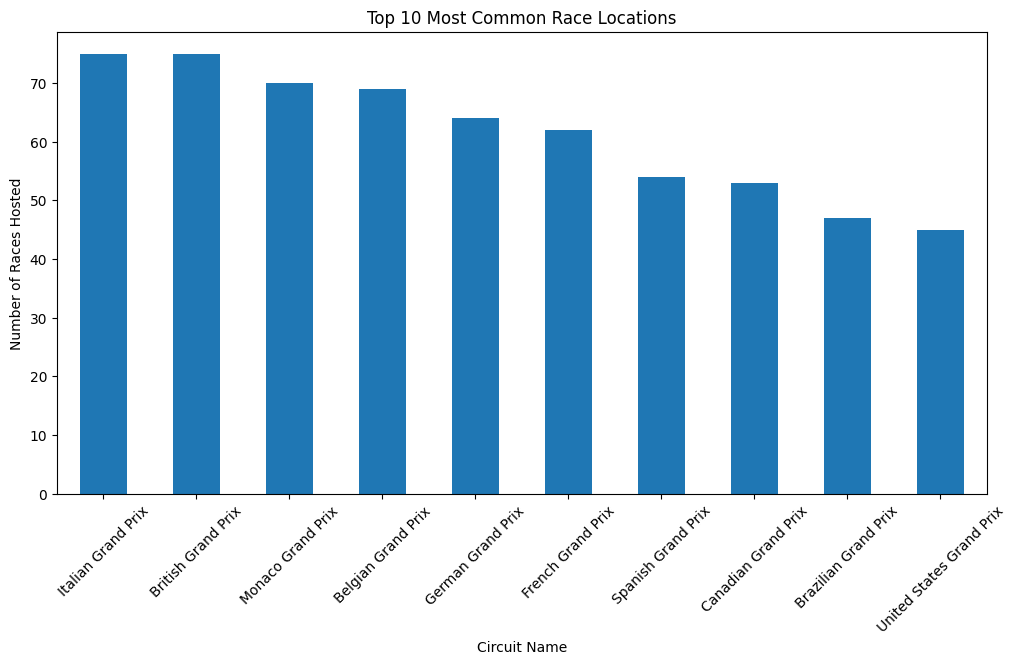

In [8]:
top_circuits = df_races['name'].value_counts().head(10)

plt.figure(figsize=(12,6))
top_circuits.plot(kind='bar')
plt.title("Top 10 Most Common Race Locations")
plt.xlabel("Circuit Name")
plt.ylabel("Number of Races Hosted")
plt.xticks(rotation=45)
plt.show()

**How strongly does qualifying position affect final race result?**

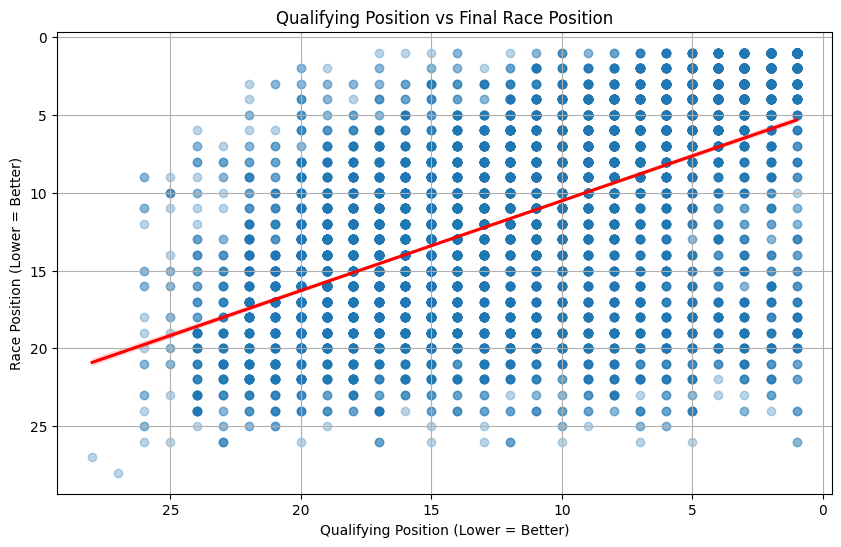

Correlation between Qualifying and Race position: 0.58


In [9]:
# Merging qualifying and results datasets on raceId and driverId
df_qual_race = pd.merge(
    df_qualifying[['raceId', 'driverId', 'position']],
    df_results[['raceId', 'driverId', 'positionOrder']],
    on=['raceId', 'driverId'],
    how='inner'
)

# Renaming columns for clarity
df_qual_race.rename(columns={'position': 'qualifying_position', 'positionOrder': 'race_position'}, inplace=True)

# Converting to numeric (in case of any string values)
df_qual_race['qualifying_position'] = pd.to_numeric(df_qual_race['qualifying_position'], errors='coerce')
df_qual_race['race_position'] = pd.to_numeric(df_qual_race['race_position'], errors='coerce')

# Dropping NaN rows if any
df_qual_race.dropna(inplace=True)

# Scatter plot with trend line
plt.figure(figsize=(10,6))
sns.regplot(data=df_qual_race, x='qualifying_position', y='race_position', scatter_kws={'alpha':0.3}, line_kws={"color":"red"})
plt.title('Qualifying Position vs Final Race Position')
plt.xlabel('Qualifying Position (Lower = Better)')
plt.ylabel('Race Position (Lower = Better)')
plt.gca().invert_xaxis()  # Because P1 is the best, so better to invert X for clarity
plt.gca().invert_yaxis()  # Same for race position
plt.grid(True)
plt.show()

# Correlation coefficient
correlation = df_qual_race['qualifying_position'].corr(df_qual_race['race_position'])
print(f"Correlation between Qualifying and Race position: {correlation:.2f}")

**Which constructors (teams) have the most Formula 1 race wins?**

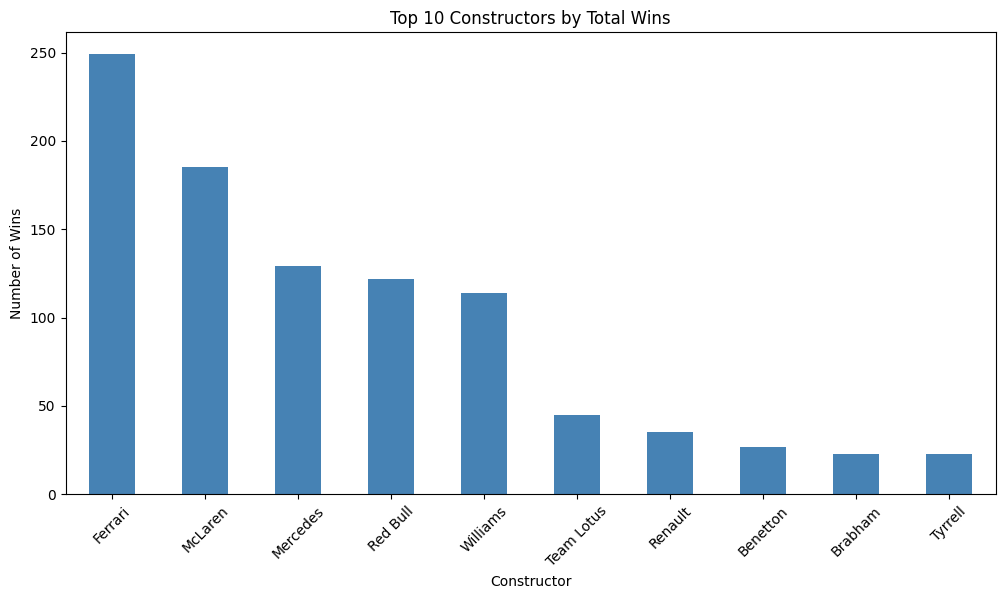

In [10]:
df_constructors = pd.read_csv(path + "/constructors.csv")

# Get winners only
winners = df_results[df_results['positionOrder'] == 1]

# Merge with constructors
winners = winners.merge(df_constructors, on='constructorId')

# Count wins
team_wins = winners['name'].value_counts().head(10)

plt.figure(figsize=(12,6))
team_wins.plot(kind='bar', color='steelblue')
plt.title("Top 10 Constructors by Total Wins")
plt.xlabel("Constructor")
plt.ylabel("Number of Wins")
plt.xticks(rotation=45)
plt.show()


**Which nationalities have produced the most Formula 1 drivers?**

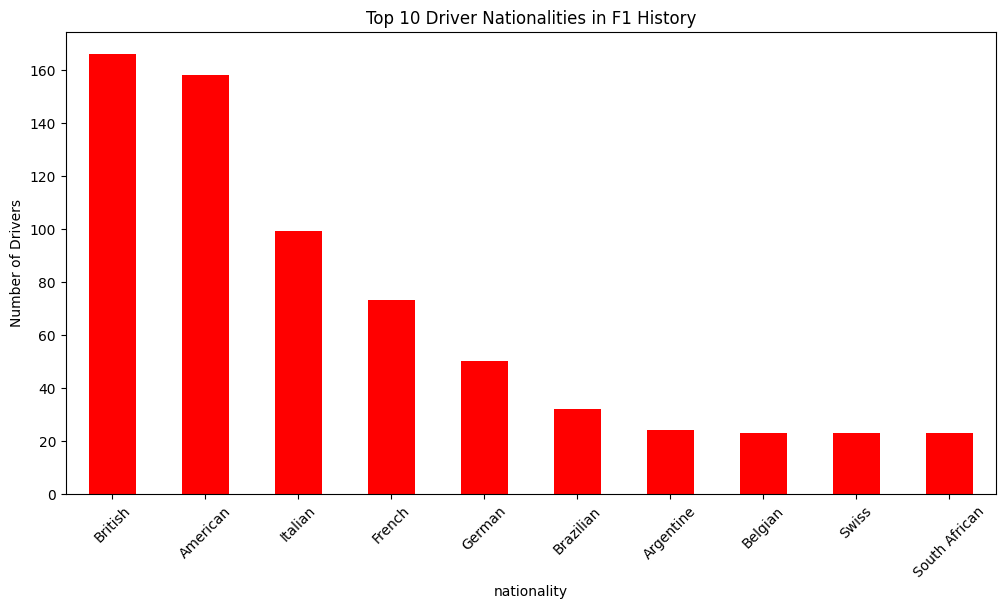

In [11]:
nationalities = df_drivers['nationality'].value_counts().head(10)

plt.figure(figsize=(12,6))
nationalities.plot(kind='bar', color='red')
plt.title("Top 10 Driver Nationalities in F1 History")
plt.ylabel("Number of Drivers")
plt.xticks(rotation=45)
plt.show()


In [12]:
# 🧠 Selecting important columns from each dataset
races_data = df_races[['raceId', 'year', 'round', 'name', 'circuitId']]
drivers_data = df_drivers[['driverId', 'forename', 'surname', 'nationality']]
qualifying_data = df_qualifying[['raceId', 'driverId', 'position']]
results_data = df_results[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'points']]

# Renaming columns for clarity
qualifying_data = qualifying_data.rename(columns={'position': 'qualifying_position'})

results_data = results_data.rename(columns={'positionOrder': 'race_position'})

# 🏎️ Step 1: Merge results with races
df_features = pd.merge(results_data, races_data, on='raceId', how='left')

# 🧑 Step 2: Add driver information
df_features = pd.merge(df_features, drivers_data, on='driverId', how='left')

# ⏱️ Step 3: Add qualifying information
df_features = pd.merge(df_features, qualifying_data, on=['raceId', 'driverId'], how='left')

# 🧼 Step 4: Handle missing qualifying values if any (fill with large number = bad position)
df_features['qualifying_position'] = df_features['qualifying_position'].fillna(30)

# 🔢 Convert qualifying position to numeric
df_features['qualifying_position'] = pd.to_numeric(df_features['qualifying_position'], errors='coerce')

# 🏁 Creating a target column — 1 if driver won the race, else 0
df_features['winner'] = df_features['race_position'].apply(lambda x: 1 if x == 1 else 0)

# drop rows with missing race position
#df_features.dropna(subset=['race_position'], inplace=True)

# Preview the final dataset
df_features.head()

,raceId,driverId,constructorId,grid,race_position,points,year,round,name,circuitId,forename,surname,nationality,qualifying_position,winner
0,18,1,1,1,1,10.0,2008,1,Australian Grand Prix,1,Lewis,Hamilton,British,1.0,1
1,18,2,2,5,2,8.0,2008,1,Australian Grand Prix,1,Nick,Heidfeld,German,5.0,0
2,18,3,3,7,3,6.0,2008,1,Australian Grand Prix,1,Nico,Rosberg,German,7.0,0
3,18,4,4,11,4,5.0,2008,1,Australian Grand Prix,1,Fernando,Alonso,Spanish,12.0,0
4,18,5,1,3,5,4.0,2008,1,Australian Grand Prix,1,Heikki,Kovalainen,Finnish,3.0,0


In [13]:
# Selecting features and target
X = df_features[['qualifying_position', 'grid', 'year', 'round', 'constructorId']]
y = df_features['winner']

# Splitting into train & test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (21407, 5)
Test shape: (5352, 5)


In [14]:
# Creating and training the model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)
log_reg.fit(X_train, y_train)

# Predictions
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

# Evaluation
print("Logistic Regression Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_lr), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_lr),2))
print("ROC-AUC:", round(roc_auc_score(y_test, y_pred_lr), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Results:
Accuracy: 0.76
F1 Score: 0.23
ROC-AUC: 0.81

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.86      5126
           1       0.13      0.86      0.23       226

    accuracy                           0.76      5352
   macro avg       0.56      0.81      0.54      5352
weighted avg       0.96      0.76      0.83      5352



In [15]:
# Creating and training the model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=200)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

# Evaluation
print("Random Forest Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_rf), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_rf),2))
print("ROC-AUC:", round(roc_auc_score(y_test, y_prob_rf), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Results:
Accuracy: 0.96
F1 Score: 0.29
ROC-AUC: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5126
           1       0.47      0.21      0.29       226

    accuracy                           0.96      5352
   macro avg       0.72      0.60      0.64      5352
weighted avg       0.95      0.96      0.95      5352



In [16]:
# scale_pos_weight helps handle imbalance
# scale_pos_weight = (negative samples / positive samples)
scale_weight = (y_train.value_counts()[0] / y_train.value_counts()[1])

# ⚡ Creating and training the model
xgb_model = XGBClassifier(
    scale_pos_weight=scale_weight,
    eval_metric='auc',
    random_state=42,
    n_estimators=300
)
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluation
print("📊 XGBoost Results:")
print("Accuracy:", round(accuracy_score(y_test, y_pred_xgb), 2))
print("F1 Score:", round(f1_score(y_test, y_pred_xgb),2))
print("ROC-AUC:", round(roc_auc_score(y_test, y_pred_xgb), 2))
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))


📊 XGBoost Results:
Accuracy: 0.92
F1 Score: 0.36
ROC-AUC: 0.72

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5126
           1       0.28      0.50      0.36       226

    accuracy                           0.92      5352
   macro avg       0.63      0.72      0.66      5352
weighted avg       0.95      0.92      0.93      5352




==================== Logistic Regression ====================
Accuracy: 0.76
F1 Score: 0.23
ROC-AUC: 0.87


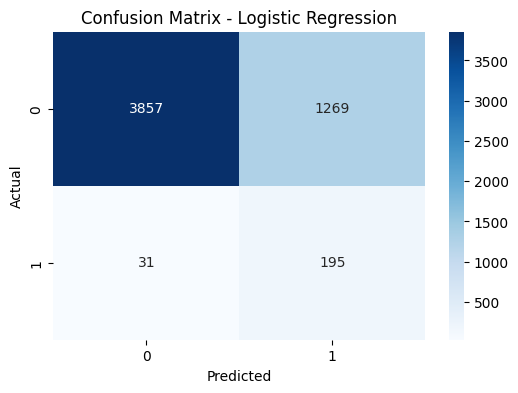


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.75      0.86      5126
           1       0.13      0.86      0.23       226

    accuracy                           0.76      5352
   macro avg       0.56      0.81      0.54      5352
weighted avg       0.96      0.76      0.83      5352


==================== Random Forest ====================
Accuracy: 0.96
F1 Score: 0.29
ROC-AUC: 0.88


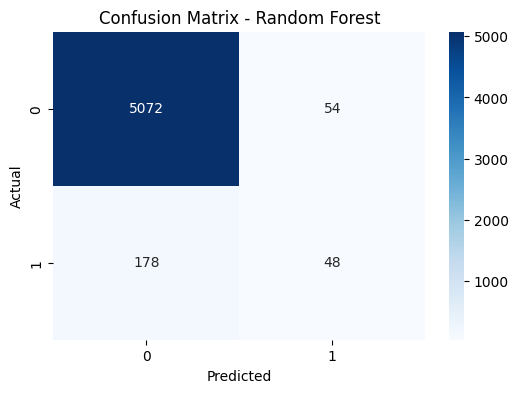


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      5126
           1       0.47      0.21      0.29       226

    accuracy                           0.96      5352
   macro avg       0.72      0.60      0.64      5352
weighted avg       0.95      0.96      0.95      5352


==================== XGBoost ====================
Accuracy: 0.92
F1 Score: 0.36
ROC-AUC: 0.9


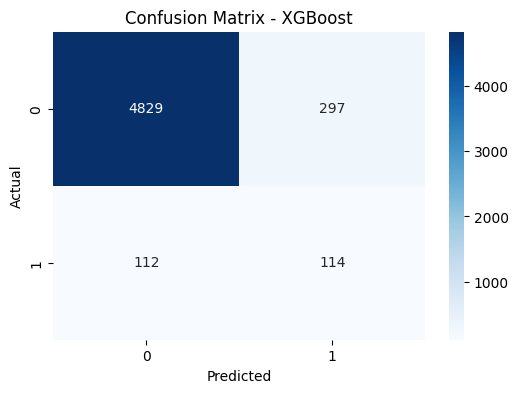


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96      5126
           1       0.28      0.50      0.36       226

    accuracy                           0.92      5352
   macro avg       0.63      0.72      0.66      5352
weighted avg       0.95      0.92      0.93      5352



In [17]:

# Models dictionary
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf_model,
    "XGBoost": xgb_model
}

# Loop through models and evaluate
for name, model in models.items():
    print(f"\n==================== {name} ====================")

    # Predictions
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = y_pred

    # Metrics
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 2))
    print("F1 Score:", round(f1_score(y_test, y_pred), 2))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 2))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # Classification Report
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

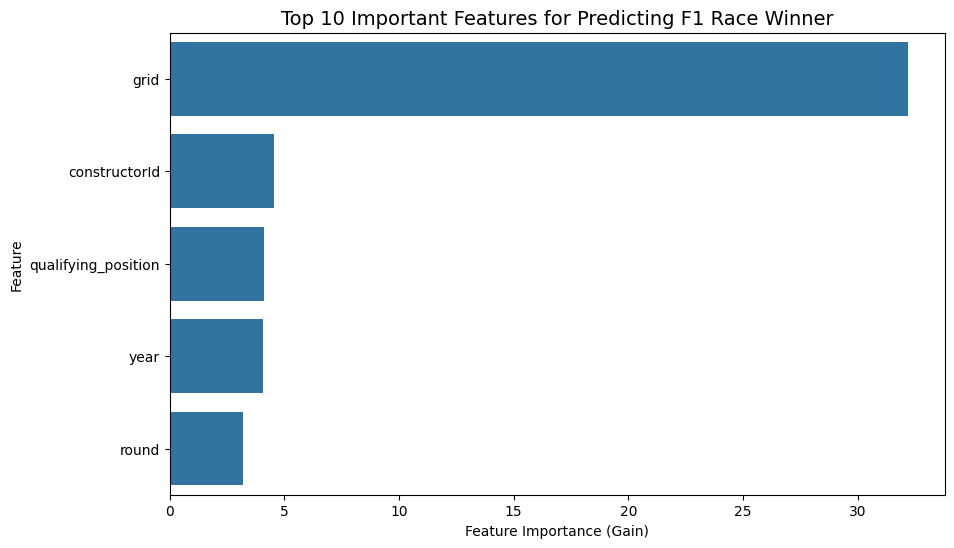

In [18]:
# Extract feature importances
importance = xgb_model.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'Feature': list(importance.keys()),
    'Importance': list(importance.values())
}).sort_values(by='Importance', ascending=False).head(10)

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Top 10 Important Features for Predicting F1 Race Winner", fontsize=14)
plt.xlabel("Feature Importance (Gain)")
plt.ylabel("Feature")
plt.show()

In [20]:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

def predict_driver_win(last_name):
    matched_drivers = df_drivers[df_drivers['surname'].str.lower() == last_name.lower()]
    if matched_drivers.empty:
        print(f"❌ No driver found with last name '{last_name}'. Check spelling and try again.")
        return

    driver_results = (
        df_results
        .merge(df_races, on='raceId', how='left')
        .merge(df_drivers, on='driverId', how='left')
        .merge(df_qualifying, on=['raceId', 'driverId'], how='left')
    )

    driver_data = driver_results[driver_results['surname'].str.lower() == last_name.lower()].sort_values(by='date', ascending=False).head(1)

    if driver_data.empty:
        print(f"❌ No race data found for {last_name}.")
        return

    feature_cols = X_test.columns
    available_features = [col for col in feature_cols if col in driver_data.columns]

    X_input = driver_data[available_features].copy()  # 👈 Copy avoids warning safely

    # Fill missing columns with 0 and align order
    for col in feature_cols:
        if col not in X_input.columns:
            X_input.loc[:, col] = 0  # 👈 .loc fixes the warning cleanly

    X_input = X_input[feature_cols]

    win_prob = xgb_model.predict_proba(X_input)[:, 1][0] * 100

    print(f"🏎️ Driver: {last_name}")
    print(f"📅 Race: {driver_data['name'].values[0]} ({driver_data['year'].values[0]})")
    print(f"🚦 Starting Grid: {driver_data['grid'].values[0]}")
    print(f"🏁 Predicted Win Probability: {win_prob:.2f}%")

# Example
predict_driver_win("Norris")

🏎️ Driver: Norris
📅 Race: Abu Dhabi Grand Prix (2024)
🚦 Starting Grid: 1
🏁 Predicted Win Probability: 98.50%
